In [1]:
import random, sys, wx, math, time
from PS3_wsim import *
import matplotlib.pyplot as p

## TDMA

In [2]:
class TDMANode(WirelessNode):
    def __init__(self,location,network,retry):
        WirelessNode.__init__(self,location,network,retry)
        # any additional state or variables may be set here

    def channel_access(self,time,ptime,numnodes):
        #print(time)
        slot_size=numnodes * ptime
        if (time % slot_size)/ptime == self.get_id():
            return True
        else:
            return False


    def on_collision(self,packet):
        ## Don't need for TDMA
        pass

    def on_xmit_success(self,packet):
        ## Don't need for TDMA
        pass

In [3]:
class TDMAWirelessNetwork(WirelessNetwork):
    def __init__(self,n,chantype,ptime,dist,load,retry,backoff,
		 skew=SOURCE_NOSKEW,qmax=0,simtime=10000):
        WirelessNetwork.__init__(self,n,chantype,ptime,dist,load,retry,backoff,
                                 skew,qmax,simtime)
    def make_node(self,loc,retry):
        return TDMANode(loc,self,retry)

Protocol: TDMA
attaching  0.5  to node  0
attaching  0.25  to node  1
attaching  0.125  to node  2
attaching  0.0625  to node  3
attaching  0.03125  to node  4
attaching  0.015625  to node  5
attaching  0.0078125  to node  6
attaching  0.00390625  to node  7
attaching  0.001953125  to node  8
attaching  0.0009765625  to node  9
attaching  0.00048828125  to node  10
attaching  0.000244140625  to node  11
attaching  0.0001220703125  to node  12
attaching  6.103515625e-05  to node  13
attaching  3.0517578125e-05  to node  14
attaching  1.52587890625e-05  to node  15
attaching  7.62939453125e-06  to node  16
attaching  3.814697265625e-06  to node  17
attaching  1.9073486328125e-06  to node  18
attaching  9.5367431640625e-07  to node  19
attaching  9.5367431640625e-07  to node  20
  Node 0 attempts 476 success 476 coll 0
  Node 1 attempts 477 success 477 coll 0
  Node 2 attempts 476 success 476 coll 0
  Node 3 attempts 476 success 475 coll 0
  Node 4 attempts 349 success 349 coll 0
  Node 5

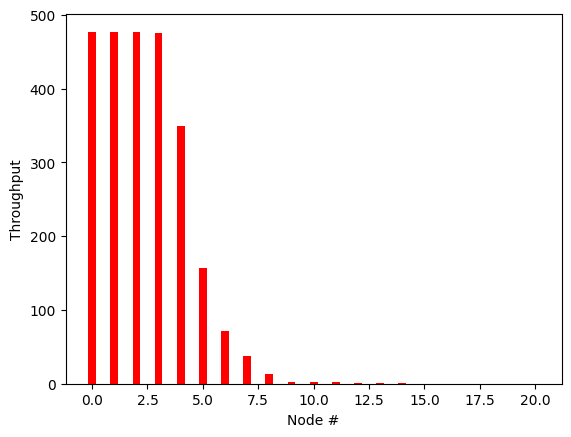

In [4]:
gui=False
numnodes=21
simtime=10000
ptime=1
load=100
retry=False
skew=True
    
print ('Protocol: TDMA')
wnet = TDMAWirelessNetwork(numnodes,'TDMA',ptime,
                               'exponential',load,retry,'None',
                               skew,0,simtime)
    
if gui == True:
    sim = NetSim()
    sim.SetNetwork(wnet)
    sim.MainLoop()
else:
    wnet.step(simtime)
    succ = []
    for node in wnet.nlist: succ.append(node.stats.success)
    for node in wnet.nlist:
        if node.stats.collisions > 0: 
            print ("ERROR! TDMA should not have collisions")
    ind = numpy.arange(len(wnet.nlist))
    width = 0.35
    p.bar(ind, succ, width, color = 'r')
    p.ylabel('Throughput')
    p.xlabel('Node #')
    p.show()

## Stabilizing ALOHA (with backoff)

In [138]:
class AlohaNode(WirelessNode):
    def __init__(self,location,network,retry):
        WirelessNode.__init__(self,location,network,retry)
        ## Your code to initialize any additional state or variables goes here
        ## You can use self.network.pmin, self.network.pmax, etc.

        # for plots of collisions/success
        self.sent = []
        self.coll = []

        # initialize local probability of transmission
        self.p = self.network.pmax

        self.pmin = self.network.pmin
        self.pmax = self.network.pmax

    def channel_access(self,time,ptime,numnodes):
        flag=random.random()
        if flag < self.p and flag > self.pmin:
            return True
        else:
            return False

    def on_collision(self,packet):
        # for plots of collisions
        self.coll.append(self.network.time)

        self.p = max(self.p*0.9,self.pmin)

    def on_xmit_success(self,packet):
        # for plots of successful transmissions
        self.sent.append(self.network.time)

        self.p = self.pmax
        

In [139]:
class AlohaWirelessNetwork(WirelessNetwork):
    def __init__(self,n,chantype,ptime,dist,load,retry,backoff,
		 skew,qmax,pmax,pmin,simtime):
        self.pmax = pmax
        self.pmin = pmin
        WirelessNetwork.__init__(self,n,chantype,ptime,dist,load,retry,backoff,
                                 skew,qmax,simtime)

    def make_node(self,loc,retry):
        return AlohaNode(loc,self,retry)

Protocol: Aloha with stabilization
  Node 0 attempts 358 success 225 coll 133
  Node 1 attempts 269 success 162 coll 107
  Node 2 attempts 210 success 125 coll 85
  Node 3 attempts 173 success 100 coll 73
  Node 4 attempts 258 success 152 coll 106
  Node 5 attempts 123 success 75 coll 48
  Node 6 attempts 348 success 216 coll 132
  Node 7 attempts 272 success 177 coll 95
Time 70000 attempts 2011 success 1232 util 0.18
Inter-node fairness: 0.91
Inter-node weighted fairness: 0.91


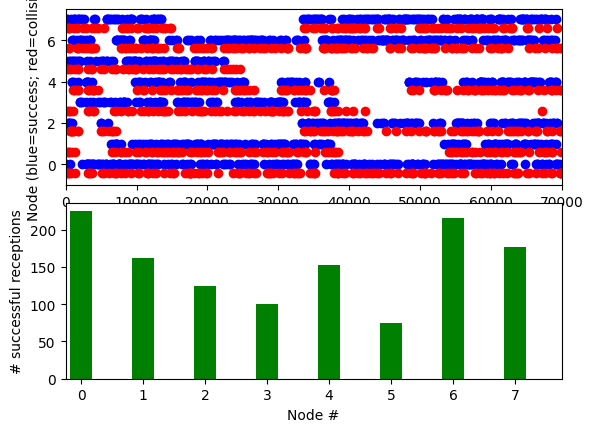

In [261]:
gui=False
numnodes=8
simtime=70000
backoff='Mine'
ptime=10
pmax=0.017
pmin=0.010
load=100
retry=True
skew=False
print ('Protocol: Aloha with stabilization')
wnet = AlohaWirelessNetwork(numnodes,'Aloha',ptime,
                            'exponential',load,retry,backoff,
                            skew,0,pmax,pmin,simtime)
    
if gui == True:
    sim = NetSim()
    sim.SetNetwork(wnet)
    sim.MainLoop()
else:
    wnet.step(simtime)
    plot_data(wnet) 

## CSMA

In [8]:
class CSMANode(WirelessNode):
    def __init__(self,location,network,retry):
        WirelessNode.__init__(self,location,network,retry)
        ## Your code to initialize any additional state or variables goes here
        ## You can use self.network.pmin, self.network.pmax, etc.

        # for plots of collisions/success
        self.sent = []
        self.coll = []

        # initialize local probability of transmission
        self.p = self.network.pmax

        self.pmin = self.network.pmin
        self.pmax = self.network.pmax


    def channel_access(self,time,ptime,numnodes):
        # You can tell if the channel is busy or not using
        # the self.network.channel_busy() function call.
        
        flag=random.random()
        if flag < self.p and flag > self.pmin and self.network.channel_idle():
            return True
        else:
            return False
        

    def on_collision(self,packet):
        # for plots of collisions
        self.coll.append(self.network.time)

        self.p = max(self.p/2,self.pmin)

        

    def on_xmit_success(self,packet):
        # for plots of successful transmissions
        self.sent.append(self.network.time)
        #self.p = min(self.p*10,self.pmax)
        self.p = self.pmax




In [9]:
class CSMAWirelessNetwork(WirelessNetwork):
    def __init__(self,n,chantype,ptime,dist,load,retry,backoff,
		 skew,qmax,pmax,pmin,simtime):
        self.pmax = pmax
        self.pmin = pmin        
        WirelessNetwork.__init__(self,n,chantype,ptime,dist,load,retry,backoff,
                                 skew,qmax,simtime)

    def make_node(self,loc,retry):
        return CSMANode(loc,self,retry)

Protocol: CSMA with stabilization
  Node 0 attempts 1532 success 986 coll 546
  Node 1 attempts 1432 success 1191 coll 241
  Node 2 attempts 1585 success 939 coll 646
  Node 3 attempts 1495 success 1010 coll 485
  Node 4 attempts 717 success 372 coll 345
  Node 5 attempts 1033 success 575 coll 458
  Node 6 attempts 1733 success 1236 coll 496
  Node 7 attempts 1934 success 1314 coll 620
Time 100000 attempts 11461 success 7623 util 0.76
Inter-node fairness: 0.91
Inter-node weighted fairness: 0.91


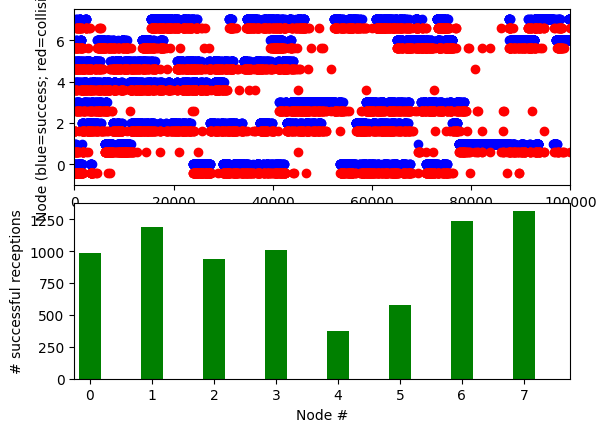

In [281]:

gui=False
numnodes=8
simtime=100000
backoff='Mine'
ptime=10
pmax=0.79
pmin=0
load=100
retry=True
skew=False
print ('Protocol: CSMA with stabilization')
wnet = CSMAWirelessNetwork(numnodes,'CSMA',ptime,
                            'exponential',load,retry,backoff,
                            skew,0,pmax,pmin,simtime)

if gui == True:
    sim = NetSim()
    sim.SetNetwork(wnet)
    sim.MainLoop()
else:
    wnet.step(simtime)
    plot_data(wnet)

## CSMA with Contention Window

In [273]:
class WinCSMANode(WirelessNode):
    def __init__(self,location,network,retry):
        WirelessNode.__init__(self,location,network,retry)
        ## Your code to initialize any additional state or variables goes here
        ## You can use self.network.cwmin, self.network.cwmax, etc.
        ## See the WinCSMAWirelessNetwork class defined below

        # for plots of collisions/success
        self.sent = []
        self.coll = []

        # initialize local cw with cwmin , t with -1
        self.cw = self.network.cwmin
        self.t=-1


        self.cw_min=self.network.cwmin
        self.cw_max=self.network.cwmax

    def channel_access(self,time,ptime,numnodes):
        # You can tell if the channel is busy or not using
        # the self.network.channel_busy() function call.
        
        
        # if self.t == -1:
        #     self.t = random.randint(1,self.cw)
        # elif self.t>0:
        #     self.t-=1
            
        # elif self.t == 0 and self.network.channel_idle():
        #     self.t=-1
        #     return True
        
        # return False
        
        
        if self.t == -1:
            self.t = random.randint(1,self.cw)
        elif self.t == 0 and self.network.channel_idle():
            self.t=-1
            return True
        elif self.network.channel_idle():
            self.t-=1
        return False
        
        
        
    def on_collision(self,packet):
        # for plots of collisions
        self.coll.append(self.network.time)

        self.cw = min(self.cw*2,self.cw_max)



    def on_xmit_success(self,packet):
        # for plots of successful transmissions
        self.sent.append(self.network.time)

        self.cw = self.cw_min

In [274]:
class WinCSMAWirelessNetwork(WirelessNetwork):
    def __init__(self,n,chantype,ptime,dist,load,retry,backoff,
		 skew,qmax,cwmin,cwmax,simtime):
        self.cwmin = cwmin
        self.cwmax = cwmax      
        WirelessNetwork.__init__(self,n,chantype,ptime,dist,load,retry,backoff,
                                 skew,qmax,simtime)

    def make_node(self,loc,retry):
        return WinCSMANode(loc,self,retry)

Protocol: Windowed CSMA with stabilization
  Node 0 attempts 775 success 364 coll 411
  Node 1 attempts 1024 success 487 coll 537
  Node 2 attempts 883 success 362 coll 521
  Node 3 attempts 840 success 385 coll 455
  Node 4 attempts 1134 success 550 coll 584
  Node 5 attempts 899 success 414 coll 485
  Node 6 attempts 648 success 294 coll 354
  Node 7 attempts 787 success 331 coll 456
  Node 8 attempts 1008 success 470 coll 538
  Node 9 attempts 880 success 370 coll 510
  Node 10 attempts 716 success 332 coll 384
  Node 11 attempts 809 success 349 coll 460
  Node 12 attempts 748 success 336 coll 412
  Node 13 attempts 739 success 319 coll 420
  Node 14 attempts 1110 success 537 coll 572
  Node 15 attempts 857 success 399 coll 458
Time 100000 attempts 13857 success 6299 util 0.63
Inter-node fairness: 0.96
Inter-node weighted fairness: 0.96


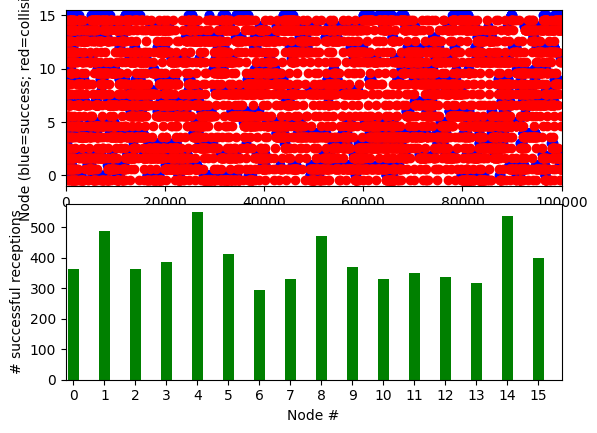

In [278]:
gui=False
numnodes=16
simtime=100000
backoff='Mine'
ptime=10
cwmin=1
cwmax=256
load=100
retry=True
skew=False
print ('Protocol: Windowed CSMA with stabilization')

wnet = WinCSMAWirelessNetwork(numnodes,'WinCSMA',ptime,
                            'exponential',load,retry,backoff,
                            skew,0,cwmin,cwmax,simtime)

if gui == True:
    sim = NetSim()
    sim.SetNetwork(wnet)
    sim.MainLoop()
else:
    wnet.step(simtime)
    plot_data(wnet)